Advanced condition
For the second type of tiling/covering

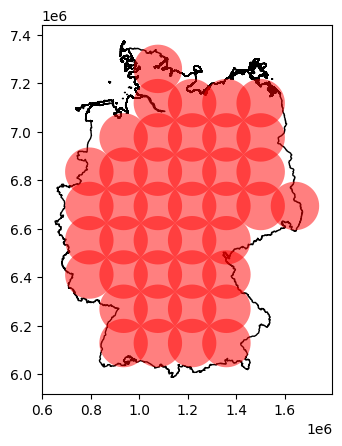

In [17]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import pandas as pd
import time

time_start = time.time()

def create_circular_grid(minx, miny, maxx, maxy, radius, crs):
    # Create a grid of points
    x_coords = np.arange(minx, maxx, radius * np.sqrt(2))
    y_coords = np.arange(miny, maxy, radius * np.sqrt(2))
    grid_points = [Point(x, y) for x in x_coords for y in y_coords]

    # Buffer the points to create circles
    grid_circles = [point.buffer(radius) for point in grid_points]

    # Get the centroids of the circles
    centroids = [circle.centroid for circle in grid_circles]

    # Convert the centroids to the specified CRS
    centroids = gpd.GeoSeries(centroids, crs=crs)

    return gpd.GeoDataFrame(geometry=grid_circles), centroids

def plot_circular_grid(filepath, radius_km, crs):
    # Load geopackage and convert to a projected CRS (UTM zone 32N for country)
    gdf = gpd.read_file(filepath)
    gdf = gdf.to_crs('EPSG:3857')

    # Get the total bounding box
    minx, miny, maxx, maxy = gdf.total_bounds

    # Convert radius to meters
    radius_m = radius_km * 1000 * 2
    grid_gdf, centroids = create_circular_grid(minx, miny, maxx, maxy, radius_m, crs)

    grid_gdf.set_crs('EPSG:3857', inplace=True)

    # Remove circles that are completely outside of the area
    grid_gdf = grid_gdf[grid_gdf.geometry.intersects(gdf.unary_union)]

    #remove circles whose centroid is outside the borders of country and updates the gird_gdf and centroids
    grid_gdf = grid_gdf[grid_gdf.centroid.intersects(gdf.unary_union)]

    # Now you can plot it
    fig, ax = plt.subplots(1, 1)
    gdf.plot(ax=ax, color='white', edgecolor='black')
    grid_gdf.plot(ax=ax, color='red', alpha=0.5)  # alpha is for transparency
    plt.show()

    return grid_gdf, centroids

# Example usage:
crs = 'EPSG:3857'  # WGS 84
grid_gdf, centroids = plot_circular_grid('gadm36_DEU.gpkg', 50, crs)


#########################################

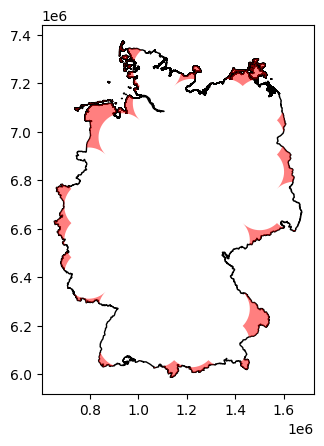

In [18]:
def plot_uncovered_areas(grid_gdf, germany, radius_km):
    gdf.to_crs('EPSG:3857', inplace=True)
    # Create a union of all the circle polygons
    circle_union = grid_gdf.geometry.unary_union

    # Perform a geometric difference operation
    uncovered_areas = germany.geometry.unary_union.difference(circle_union)

    # Convert the uncovered areas to a GeoSeries and explode it
    uncovered_areas = gpd.GeoSeries(uncovered_areas)
    uncovered_areas = uncovered_areas.explode(index_parts=True)

    # Now you can plot it
    fig, ax = plt.subplots(1, 1)
    germany.plot(ax=ax, color='white', edgecolor='black')
    uncovered_areas.plot(ax=ax, color='red', alpha=0.5)  # alpha is for transparency
    plt.show()

    return uncovered_areas

filepath = 'gadm36_DEU.gpkg'
gdf = gpd.read_file(filepath)
gdf = gdf.to_crs('EPSG:3857')

# Example usage:
uncovered_areas = plot_uncovered_areas(grid_gdf, gdf, 50)


to avoid unecessary circles, in each step of recursion, we add 1 circle to an uncovered area, and then recalculate the intersections, because often one circle can cover multiple uncovered areas. This leads to the least amount of circles possible with this method

Future improvement could be achieved by calculating which uncovered centroid we should cover first that reduces the amount of uncovered areas by the highest amount, however this would be computationally intensive and only give a marginal benefit

In [19]:
def cover_uncovered_areas(grid_gdf, germany, radius_km, total_uncovered=None, prev_uncovered=None):
    
    # Creates a list of uncovered areas
    circle_union = grid_gdf.geometry.unary_union
    uncovered_areas = germany.geometry.unary_union.difference(circle_union)
    uncovered_areas = gpd.GeoSeries(uncovered_areas)
    uncovered_areas = uncovered_areas.explode(index_parts=True)

    # If this is the first call to the function, set the total number of uncovered areas
    if total_uncovered is None:
        total_uncovered = len(uncovered_areas)
        print(f'Total uncovered areas: {total_uncovered}')

    if not uncovered_areas.empty:
        # Get the first uncovered area
        first_uncovered_area = uncovered_areas.iloc[0]

        # Calculate the centroid of the first uncovered area
        centroid = first_uncovered_area.centroid

        #check if the centroid is within Germany
        if germany.geometry.unary_union.contains(centroid):
            # Create a new GeoDataFrame for the centroid
            new_gdf = gpd.GeoDataFrame(geometry=[centroid.buffer(radius_km * 1000*2)], crs=grid_gdf.crs)
            # Concatenate the new GeoDataFrame with the original one
            grid_gdf = pd.concat([grid_gdf, new_gdf], ignore_index=True)
        
            #recalculate the circle union and the uncovered areas
            circle_union = grid_gdf.geometry.unary_union
            uncovered_areas = germany.geometry.unary_union.difference(circle_union)
            uncovered_areas = gpd.GeoSeries(uncovered_areas)
            uncovered_areas = uncovered_areas.explode(index_parts=True)
            print("remaining uncovered areas: " + str(len(uncovered_areas)))

            if uncovered_areas.empty or all(area.is_empty for area in uncovered_areas):

                return grid_gdf

    # If not all areas are empty, make a recursive call
    if not uncovered_areas.empty:
        grid_gdf = cover_uncovered_areas(grid_gdf, germany, radius_km, total_uncovered, len(uncovered_areas))

    return grid_gdf

radius_km = 50  
filepath = 'gadm36_DEU.gpkg'
germany = gpd.read_file(filepath)
germany = germany.to_crs('EPSG:3857')

# Call the function
result = cover_uncovered_areas(grid_gdf, gdf, radius_km)

# Print the result
print(result)

Total uncovered areas: 101
remaining uncovered areas: 93
remaining uncovered areas: 79
remaining uncovered areas: 56
remaining uncovered areas: 53
remaining uncovered areas: 52
remaining uncovered areas: 52
remaining uncovered areas: 51
remaining uncovered areas: 50
remaining uncovered areas: 50
remaining uncovered areas: 46
remaining uncovered areas: 42
remaining uncovered areas: 41
remaining uncovered areas: 40
remaining uncovered areas: 38
remaining uncovered areas: 37
remaining uncovered areas: 35
remaining uncovered areas: 39
remaining uncovered areas: 37
remaining uncovered areas: 34
remaining uncovered areas: 33
remaining uncovered areas: 29
remaining uncovered areas: 27
remaining uncovered areas: 8
remaining uncovered areas: 7
remaining uncovered areas: 6
remaining uncovered areas: 5
remaining uncovered areas: 2
remaining uncovered areas: 1
remaining uncovered areas: 1
                                             geometry
0   POLYGON ((894449.376 6410541.010, 893967.849 6...
1 

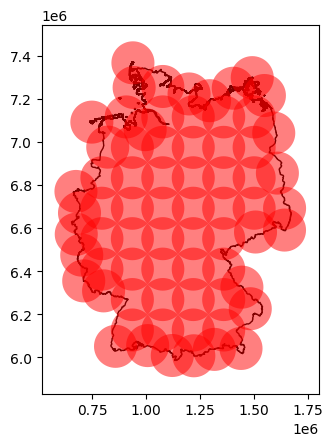

time elapsed: 42.42163300514221


In [20]:
def plot_circles_on_map(grid_gdf, germany_filepath):
    # Load geopackage and convert to a projected CRS (UTM zone 32N for country)
    germany = gpd.read_file(germany_filepath)
    germany = germany.to_crs('EPSG:3857')

    # Now you can plot it
    fig, ax = plt.subplots(1, 1)
    germany.plot(ax=ax, color='white', edgecolor='black')
    grid_gdf.plot(ax=ax, color='red', alpha=0.5)  # alpha is for transparency
    plt.show()

# Example usage:
plot_circles_on_map(result, filepath)

time_end = time.time()
print("time elapsed: " + str(time_end - time_start))